``` bash
python launch_sst2_pdb.py -pdb 5awl.pdb -dir tmp_CLN025_sst2_10_rung_5awl -n CLN025 -pad 1.5 -eq_time_expl 10 -time 1000 -temp_num 10 -min_temp 280 -temp_time 10
```

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import MDAnalysis as mda
import nglview as nv 
from scipy.ndimage import gaussian_filter1d
from cmcrameri import cm

import sys
sys.path.append('/home/murail/Documents/Code/SST2/src')
import SST2.analysis.data_plot as data_plot
import SST2.analysis.trajectory as trajectory

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 3.5)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['legend.fontsize'] = 8

sns.set_theme(
    context="paper",
    style="white",
    rc = {
    'axes.grid' : True,
    "grid.color": 'grey',
    "grid.linestyle": 'dotted',
    'xtick.bottom': True,
    'xtick.top': False,
    'ytick.left': True,
    'ytick.right': False,
})
sns.set_palette("tab10")

- prepare ref pdb:

```
vmd 2O02.pdb
[atomselect top "not chain A P"] set chain O
[atomselect top "chain P"] set chain B
[atomselect top "not chain O and not altloc B C D"] writepdb 2O02_clean.pdb
quit

```

In [3]:
name = 'CLN025'

OUT_PATH = f'CLN025_sst2_10_rung_5awl_2ps_pad_3.0_1/'
colorscale = cm.roma
ref_coor = [f'5awl.pdb']

ref_name = ref_coor[0][:4]

name_fig = f'{name}_10_rung_540K_1'
OUT_FIG = 'fig'

start_pdb = f'{OUT_PATH}/{name}_water.pdb'
first_pdb = f'{OUT_PATH}/{name}_water.pdb'

max_graph_point = 50000
skip_frame = 20
dt = 0.004

ref_Sel = "protein and chainID A and resid 2:9"
pep_Sel = "protein and chainID A and resid 2:9"

show_weights = True
use_only_300 = False

if not os.path.exists(OUT_FIG):
    os.makedirs(OUT_FIG)

time_ax_name = r"$Time\;(\mu s)$"

In [4]:
df_all = data_plot.read_SST2_data(
    f'{OUT_PATH}/{name}_sst2',
    dt=dt)

In [5]:
df_all.tail(5)

,Aim Temp (K),E solute scaled (kJ/mole),E solute not scaled (kJ/mole),E solvent (kJ/mole),E solvent-solute (kJ/mole),Step,Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Speed (ns/day),$Time\;(\mu s)$,Temp (K),lambda,$\lambda$
4999995,280.0,-651.042,461.973,-168846,-2581.81,2499998000,-171753.806963,-141179.733737,300.475224,612,9.999992,280.0,1.071429,1.07
4999996,300.0,-632.510,479.094,-168368,-2657.72,2499998500,-171179.301503,-140711.595159,299.429874,612,9.999994,300.0,1.000000,1.00
4999997,280.0,-668.623,403.120,-168343,-2672.52,2499999000,-171422.740049,-140877.372995,300.193106,612,9.999996,280.0,1.071429,1.07
4999998,280.0,-690.296,483.323,-168950,-2563.98,2499999500,-171859.879102,-141206.505316,301.254572,612,9.999998,280.0,1.071429,1.07
4999999,300.0,-578.485,443.757,-168858,-2729.83,2500000000,-171723.022834,-141230.068540,299.678005,612,10.000000,300.0,1.000000,1.00


In [6]:
temp_list = df_all['Aim Temp (K)'].unique()
temp_num = len(temp_list)
min_temp = temp_list[0]
max_temp = temp_list[-1]
print(f' {temp_num} Temperature ladder, min={min_temp:.1f} max={max_temp:.1f}')

 10 Temperature ladder, min=280.0 max=540.0


## Exchange probability & Round trip time


Temp change freq   = 0.814
Round trip time is = 0.736 ns 


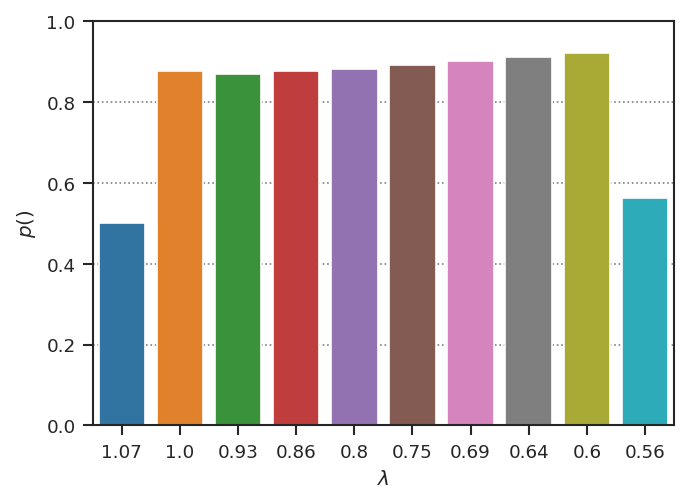

In [7]:
ex_prob, trip_time = data_plot.compute_exchange_prob(
    df_all,
    exchange_time=2,
    temp_col=r'$\lambda$')

plt.ylim(0,1)
print(f'Temp change freq   = {ex_prob:.3f}')
if trip_time is not None:
    print(f"Round trip time is = {trip_time:.3f} ns ")

## Temperature swap

<Axes: xlabel='$Time\\;(\\mu s)$', ylabel='Aim Temp (K)'>

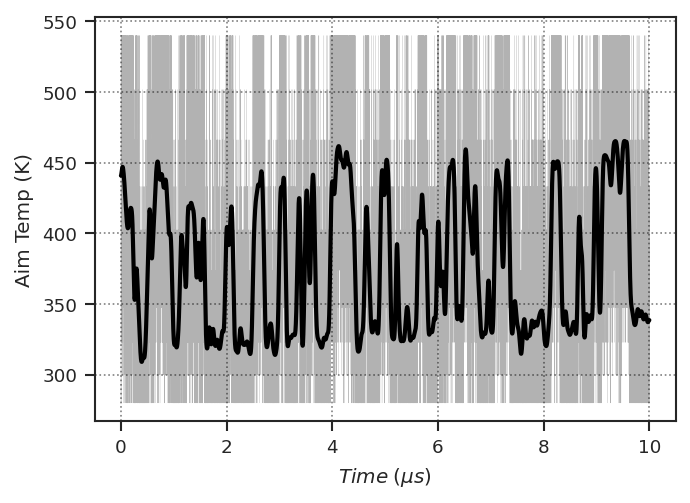

In [8]:
data_plot.plot_lineplot_avg(
    df_all,
    x=time_ax_name,
    y='Aim Temp (K)',
    max_data=max_graph_point,
    avg_win=100)

In [9]:
df_all['lambda'] = 300/df_all['Aim Temp (K)']

df_all['E solvent-solute (kJ/mole) scaled'] = 0.5*(df_all['lambda'])**0.5 * df_all['E solvent-solute (kJ/mole)'] 

df_all["new_pot"] = df_all['E solute scaled (kJ/mole)']  +\
    0.5*(df_all['lambda'])**0.5 * df_all['E solvent-solute (kJ/mole)'] 

In [10]:
if False:
    analysis.plot_energie_swap_convergence_diff(
        df_all, lag_num = 3,
        ylabel=r'$\Delta E_{pp} + \frac{1}{2} \sqrt{\frac{\beta_0}{\beta_m}} E_{pw}\; (KJ.mol^{-1})$',
        avg_start=10)

In [11]:
if False:
    plt.rcParams['figure.figsize'] = (5, 13.5)
    analysis.plot_energie_swap_convergence(
        df_all, lag_num = 25,
        ylabel=r'$\Delta E_{pp} + \frac{1}{2} \sqrt{\frac{\beta_0}{\beta_m}} E_{pw}\; (KJ.mol^{-1})$',
        split_graph=False, avg_start=5)

    plt.savefig(f'{OUT_FIG}/{name_fig}_e_swap.pdf', bbox_inches='tight')

    plt.rcParams['figure.figsize'] = (5, 3.5)

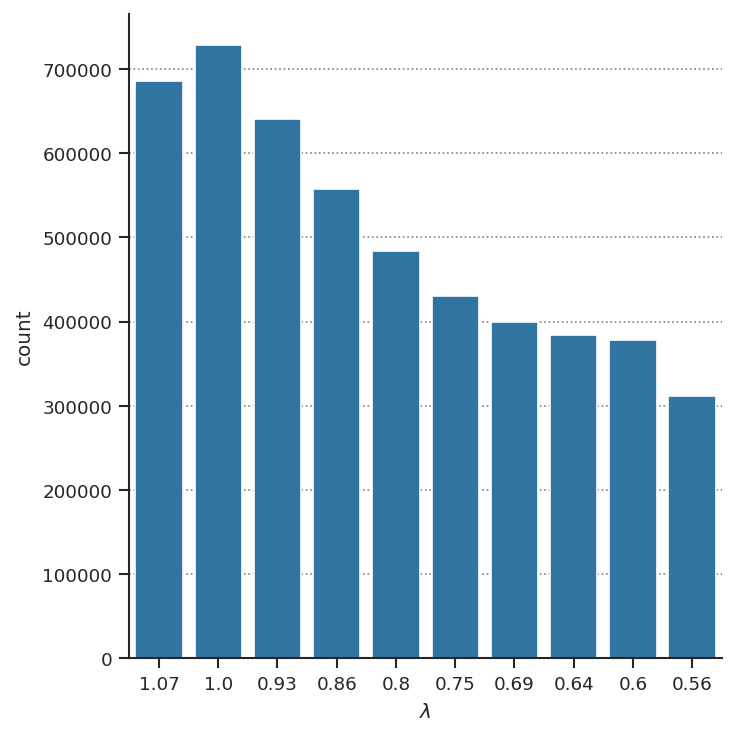

In [12]:
sns.catplot(
    df_all,
    x=r'$\lambda$',
    kind="count",                    
)
plt.savefig(f'{OUT_FIG}/{name_fig}_rung_dens.png')

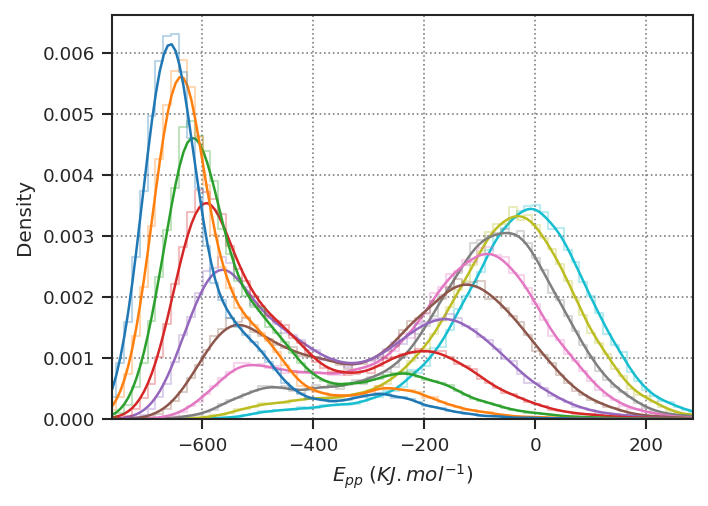

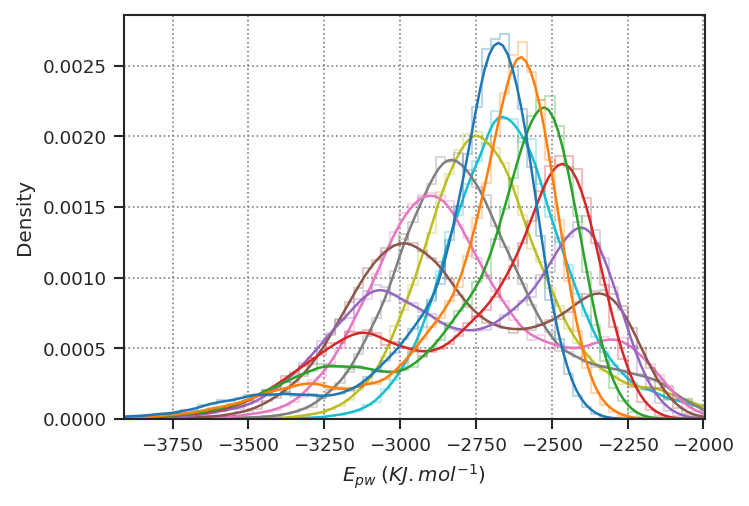

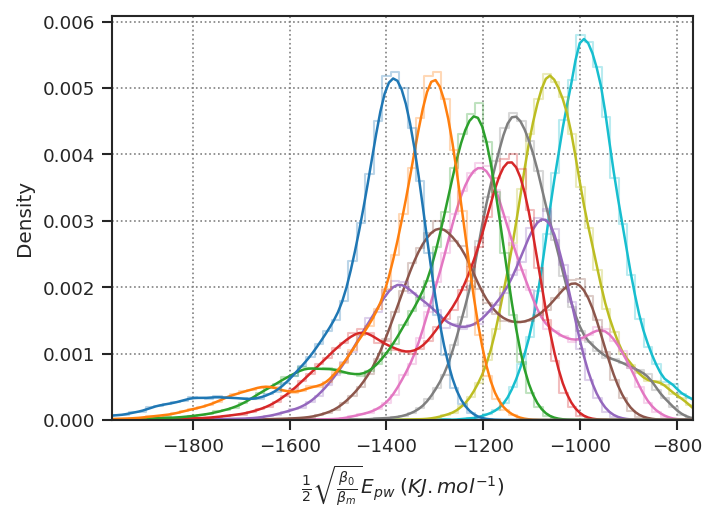

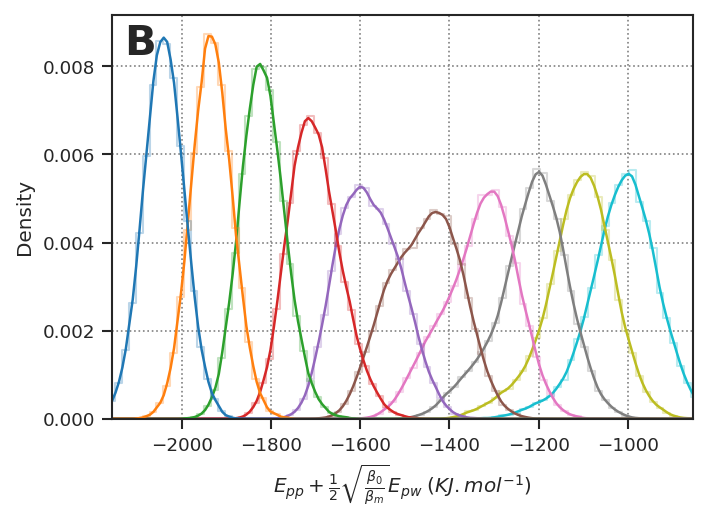

In [13]:
x_list = ["E solute scaled (kJ/mole)",
          'E solvent-solute (kJ/mole)',
          'E solvent-solute (kJ/mole) scaled',
          "new_pot"]

x_label_list = [
    r'$E_{pp}\; (KJ.mol^{-1})$',
    r'$E_{pw}\; (KJ.mol^{-1})$',
    r'$\frac{1}{2}\sqrt{\frac{\beta_0}{\beta_m}} E_{pw}\; (KJ.mol^{-1})$',
    r'$E_{pp} + \frac{1}{2} \sqrt{\frac{\beta_0}{\beta_m}} E_{pw}\; (KJ.mol^{-1})$']

label_num = 0

for x, x_label in zip(x_list, x_label_list):
    label_num += 1
    ax = data_plot.plot_distri_norm(
        df_all, 
        x=x,
        hue=r"$\lambda$",
        x_label=x_label,
        max_data=500000,
        bins=100, quant=0.001
    )
    #plt.grid()
    #plt.show()

    if label_num == 4:
        ax.text(0.02, 0.90, "B", transform=ax.transAxes, 
                size=20, weight='bold')
    
    ax.get_legend().remove()
    plt.savefig(f'{OUT_FIG}/{name_fig}_e_distri_{label_num}.pdf', dpi=300, bbox_inches='tight')

<Axes: xlabel='$E_{pp}\\;(KJ.mol^{-1})$', ylabel='$E_{pw}\\;(KJ.mol^{-1})$'>

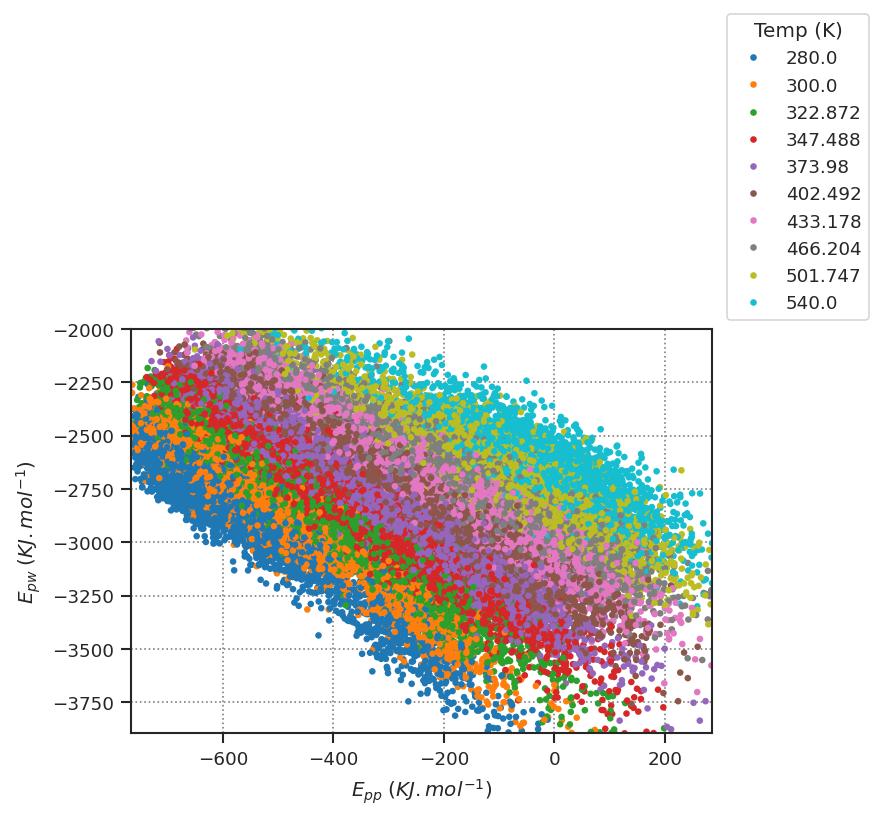

In [14]:
data_plot.plot_scatter(
    df_all,
    'E solute scaled (kJ/mole)',
    'E solvent-solute (kJ/mole)',
    "Temp (K)",
    r'$E_{pp}\;(KJ.mol^{-1})$',
    r'$E_{pw}\;(KJ.mol^{-1})$',
    quant=0.001
)

#plt.legend(title="Temp (K)", bbox_to_anchor=(1.0, 0.3))

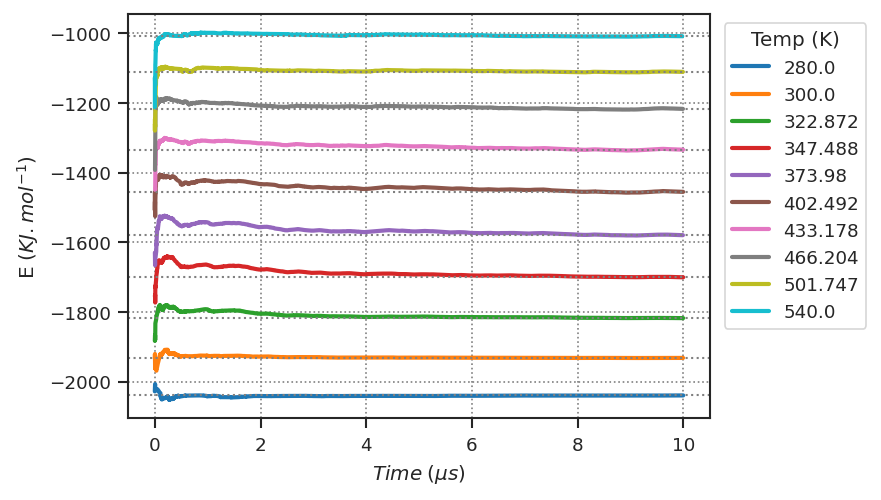

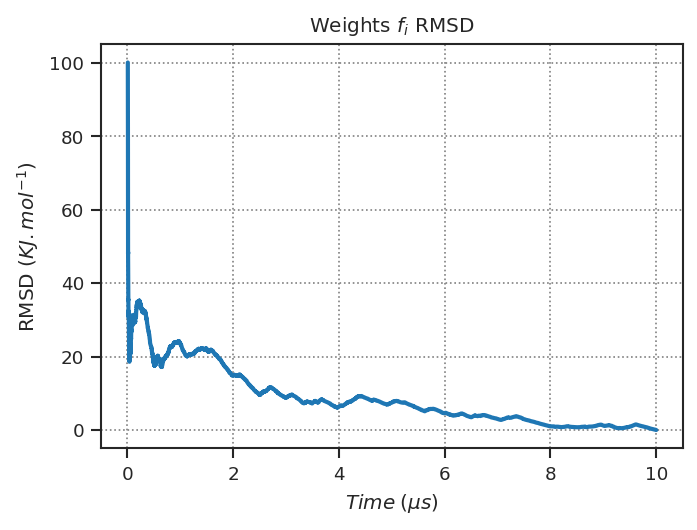

In [15]:
if show_weights:
    data_plot.plot_weight_RMSD(df_all, plot_weights=True)
    #plt.grid()

In [16]:
#df_tmp = analysis.compute_trapezoid_sst2_weights(df_all)

### Save only every 10 steps

```
mdconvert villin_10_micros_sim_temp_fly/villin_sim_temp.dcd -o villin_10_micros_sim_temp_fly/villin_sim_temp_skip100.xtc -s 20
```

In [17]:
md = trajectory.read_traj(
    start_pdb,
    f'{OUT_PATH}/{name}_sst2')

md_noh = md.select_atoms("protein and not name H*")

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [18]:
print(f'traj len : {len(md.trajectory)}')
print(f'all csv  : {len(df_all)/20}')

traj len : 250000
all csv  : 250000.0


In [19]:
df_all = df_all[::20].reset_index()

In [20]:
print(f'traj len : {len(md.trajectory)}')
print(f'all csv  : {len(df_all)}')

max_step = min([len(md.trajectory), len(df_all)])
print(f'Max step = {max_step}')

df_all = df_all[:max_step]
step_300K_index = np.where(df_all['Aim Temp (K)'] == min_temp)[0]
print(len(step_300K_index))

traj len : 250000
all csv  : 250000
Max step = 250000
34262


In [21]:
steps_num = len(step_300K_index)

md_step = 1

while steps_num > max_graph_point:
    md_step += 1
    steps_num = len(step_300K_index) // md_step

print(md_step, len(step_300K_index) // md_step)

1 34262


In [22]:
md_noh.write(f'{OUT_PATH}/noh_300K_skip.pdb',
             frames=md.trajectory[:1])
if use_only_300:
    md_noh.write(f'{OUT_PATH}/noh_300K_skip.xtc',
                 frames=md.trajectory[step_300K_index][::md_step],
                 verbose=True)
    traj_filter = f'{OUT_PATH}/noh_300K_skip.xtc'
    df_300 = df_all.loc[step_300K_index][::md_step].reset_index()
    df_300.to_csv(f'{OUT_PATH}/300K_data.csv', index=False, index_label=None)

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [23]:
if not use_only_300:
    steps_num = len(md.trajectory)

    #md_step = 1
    #while steps_num > max_graph_point:
    #    md_step += 1
    #    steps_num = len(md.trajectory) // md_step
    md_step = skip_frame

    print(md_step, len(md.trajectory) // md_step)

    df_300 = df_all.loc[:max_step:md_step].reset_index()
    df_300.to_csv(f'{OUT_PATH}/all_data.csv', index=False, index_label=None)

    print(len(df_300))
    
    md_noh.write(f'{OUT_PATH}/noh_skip.xtc',
             frames=md.trajectory[:max_step:md_step],
             verbose=True)
    traj_filter = f'{OUT_PATH}/noh_skip.xtc'

20 12500
12500


In [24]:
#%%time
#%%bash -s "$start_pdb" "$traj_xtc" "$md_step" "$out_pre" "$max_step"
#echo $1 $2 $3 $4 $5
#vmd -e filter_xtc.tcl -dispdev text -args $1 $2 $3 $4 $5

In [25]:
ref = mda.Universe(*ref_coor)

import openmm.app as app

pdbfile = app.PDBFile(f'{OUT_PATH}/noh_300K_skip.pdb')

md = mda.Universe(pdbfile,
                  traj_filter,
                  in_memory=True)

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [26]:
print(f'traj len : {len(md.trajectory)}')
print(f'all csv  : {len(df_300)}')


traj len : 12500
all csv  : 12500


In [27]:
trajectory.prepare_traj(md, ref_Sel)
trajectory.align_traj(md, ref, ref_Sel)
trajectory.align_traj(ref, ref, ref_Sel)

IntProgress(value=0, max=12500)

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/core/groups.py:445: DeprecationWarning: The 'pbc' kwarg has been deprecated and will be removed in version 3.0., please use 'wrap' instead
  warnings.warn("The 'pbc' kwarg has been deprecated and will be "


  0%|          | 0/12500 [00:00<?, ?it/s]

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/core/universe.py:658: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
import MDAnalysis.analysis.rms

R = MDAnalysis.analysis.rms.RMSD(
        md,
        ref,
        select=f"backbone and ({ref_Sel})",
        groupselections=[f"backbone and ({pep_Sel})"],
        verbose=True)
R.run()

rmsd = R.results.rmsd.T
df_300['RMSD (nm)'] = rmsd[3] / 10

  0%|          | 0/12500 [00:00<?, ?it/s]

<Axes: xlabel='$Time\\;(\\mu s)$', ylabel='RMSD (nm)'>

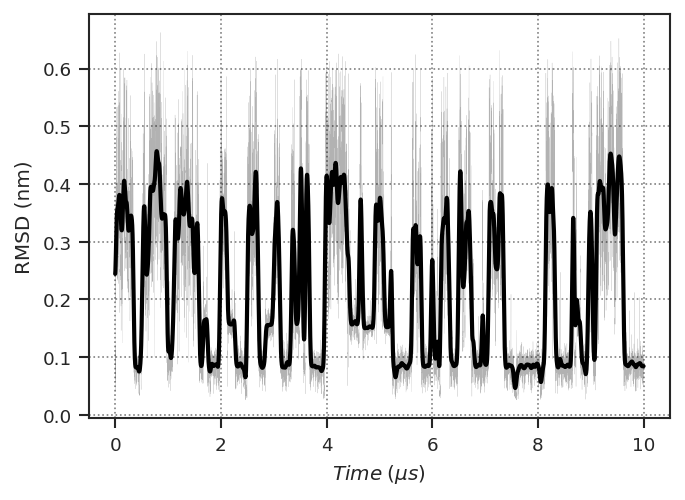

In [29]:
data_plot.plot_lineplot_avg(
    df_300,
    x=time_ax_name,
    y="RMSD (nm)",
    avg_win=20)

In [30]:
first_md = mda.Universe(first_pdb,
                        in_memory=True)

CA_pep_ref = first_md.select_atoms(f"({pep_Sel}) and name CA")
ref_com = CA_pep_ref.center_of_mass()
print("Ref Com",ref_com)

CA_pep = md.select_atoms(f"({pep_Sel}) and name CA")

com_dist = []

for ts in md.trajectory:
    #print("Frame: {0:5d}, Time: {1:8.3f} ps".format(ts.frame, md.trajectory.time))
    com = CA_pep.center_of_mass()
    com_dist.append(np.linalg.norm(ref_com - com))

df_300['COM dist (Å)'] = com_dist

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/core/universe.py:658: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


Ref Com [17.87512493 20.09887505  8.19300002]


In [31]:
com_dist_show = False

if com_dist_show:
    df_300['COM dist (Å)'] = com_dist
    df_300['COM_dist_sig6'] = gaussian_filter1d(df_300["COM dist (Å)"], 50)

    ax = sns.scatterplot(
        data=df_300,
        x=time_ax_name,
        y='COM dist (Å)',
        linewidth=0, s=2)

    ax = sns.scatterplot(
        data=df_300,
        x=time_ax_name,
        y="COM_dist_sig6",
        linewidth=0, s=2)

## Gyration radius

In [32]:
pep = md.select_atoms(f"({pep_Sel})")

gyr = []

for ts in md.trajectory:
    #print("Frame: {0:5d}, Time: {1:8.3f} ps".format(ts.frame, md.trajectory.time))
    gyr.append(pep.radius_of_gyration())

df_300['Gyration radius (nm)'] = [i/10 for i in gyr]

Text(0, 0.5, 'Gyration radius (nm)')

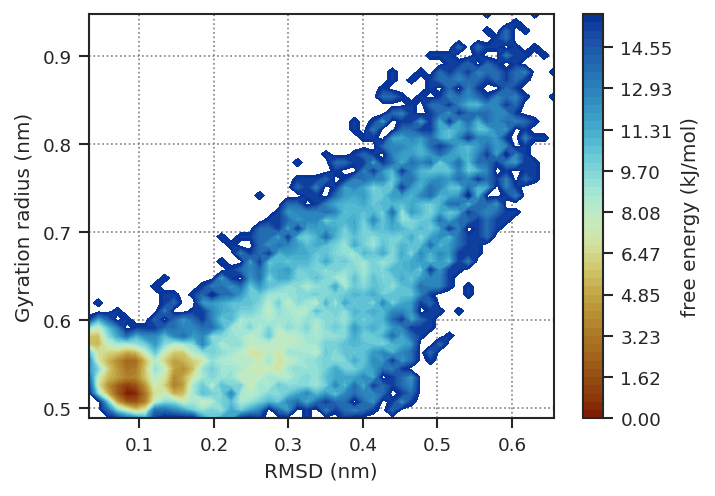

In [33]:
data_plot.plot_free_energy(
    df_300["RMSD (nm)"],df_300['Gyration radius (nm)'], 
    ncontours=50, nbins=50,
    cmap=colorscale)#,
    #avoid_zero_count=True)
plt.xlabel("RMSD (nm)")
plt.ylabel('Gyration radius (nm)')

## Fraction of native contact

In [34]:
df_300['Native Contact'] = trajectory.compute_native_contact(md, ref, 'protein and not name H*')

  0%|          | 0/12500 [00:00<?, ?it/s]

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:496: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


<Axes: xlabel='$Time\\;(\\mu s)$', ylabel='Native Contact'>

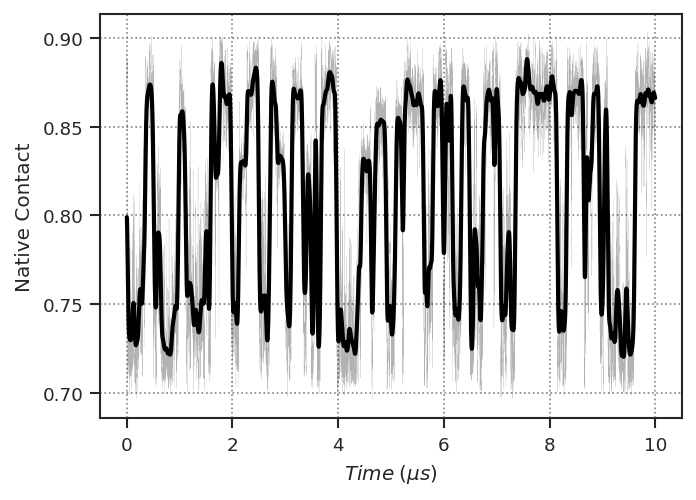

In [35]:
data_plot.plot_lineplot_avg(
    df_300,
    x=time_ax_name,
    y='Native Contact',
    avg_win=20)

Text(0, 0.5, 'Native contact')

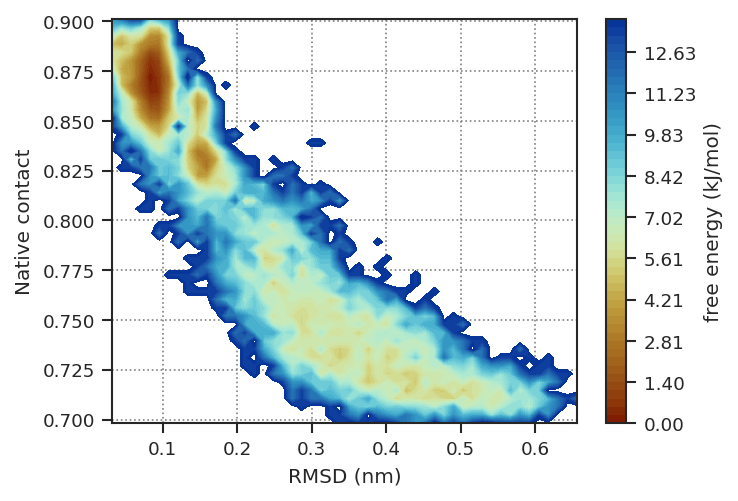

In [36]:
data_plot.plot_free_energy(
    df_300["RMSD (nm)"], df_300['Native Contact'], 
    ncontours=50, nbins=50,
    cmap=colorscale)#,
    #avoid_zero_count=True)
plt.xlabel("RMSD (nm)")
plt.ylabel('Native contact')

<Axes: xlabel='$Time\\;(\\mu s)$', ylabel='Potential Energy (kJ/mole)'>

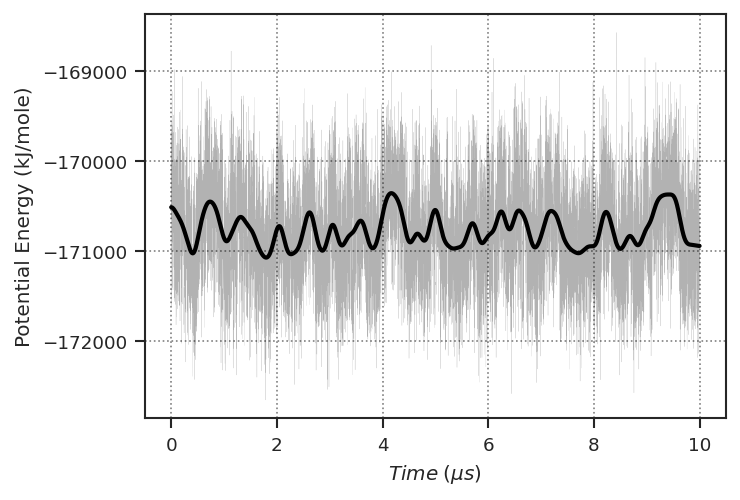

In [37]:
data_plot.plot_lineplot_avg(
    df_300,
    x=time_ax_name,
    y="Potential Energy (kJ/mole)",
    avg_win=100)

<Axes: xlabel='$Time\\;(\\mu s)$', ylabel='new_pot'>

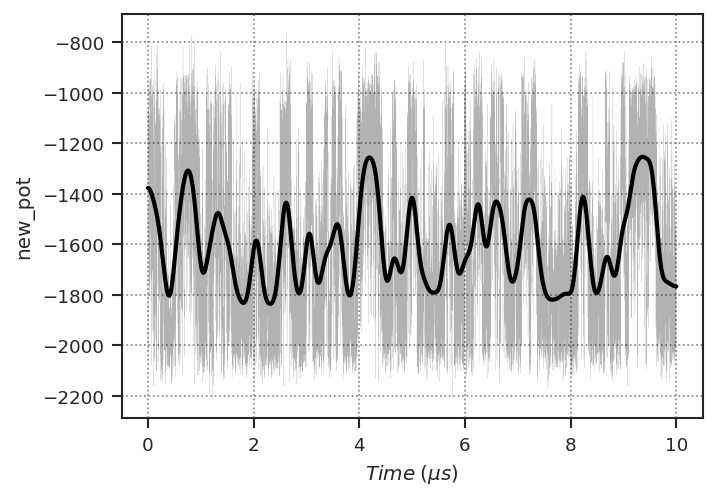

In [38]:
data_plot.plot_lineplot_avg(
    df_300,
    x=time_ax_name,
    y="new_pot",
    avg_win=100)

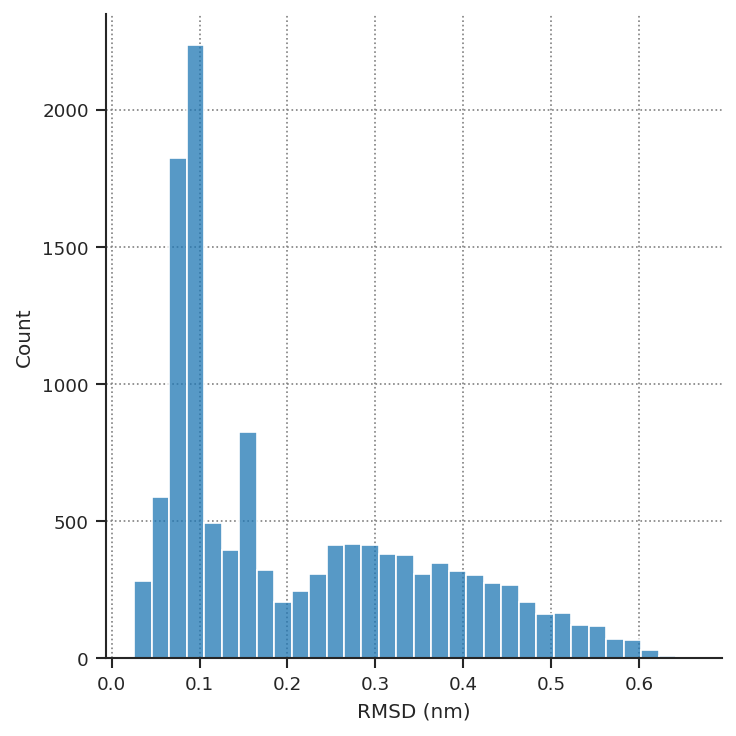

In [39]:
ax = sns.displot(df_300["RMSD (nm)"])

## Compute PCA

  0%|          | 0/12500 [00:00<?, ?it/s]

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/analysis/pca.py:337: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


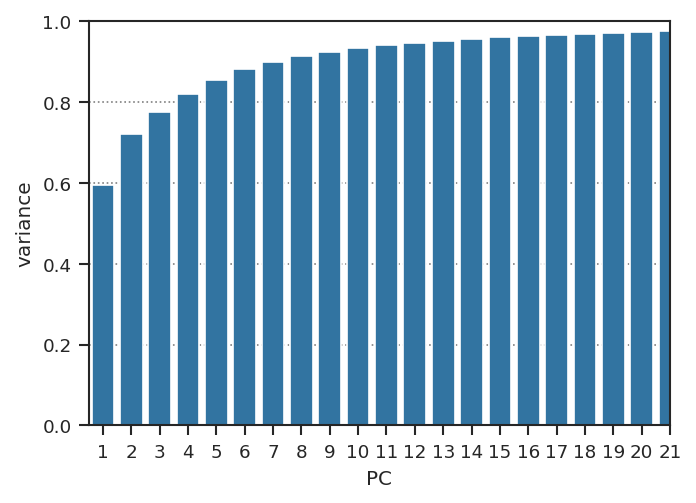

In [40]:
prot_pca, pca_df, pca_ref_df = trajectory.compute_pca(md, ref, sel='backbone', cum_var=0.8)
df_300['PC_1'] = pca_df['PC_1']
df_300['PC_2'] = pca_df['PC_2']

## Plot density for PC 1-2

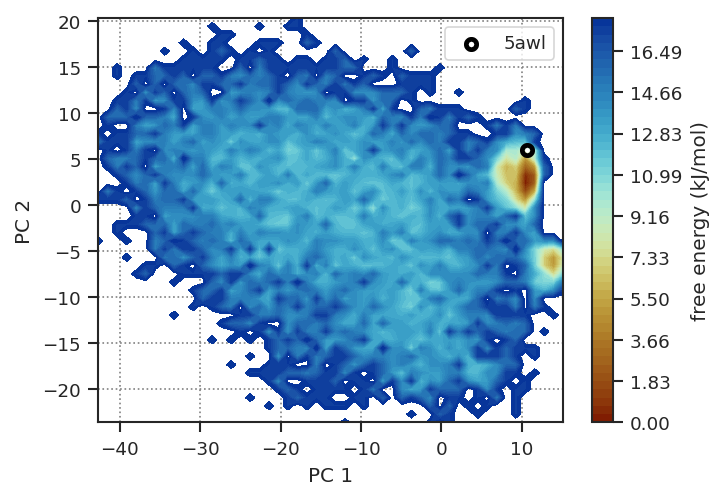

In [41]:
data_plot.plot_free_energy(
    pca_df.PC_1,
    pca_df.PC_2,
    nbins=50,
    ncontours=50,
    cmap=colorscale)#,
    #avoid_zero_count=True)

plt.scatter(pca_ref_df.PC_1, pca_ref_df.PC_2,
            color='white', s=5, linewidth=5,
            edgecolor = 'black',
            label=ref_name)
plt.legend()
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.savefig(f'{OUT_FIG}/{name_fig}_PC_1_2_free_ener.png', dpi=300)

## Clustering with HDBSCAN

In [42]:
df_300['clust'] = data_plot.compute_cluster_hdbscan(pca_df)

<Axes: xlabel='$Time\\; (\\mu s)$', ylabel='cluster'>

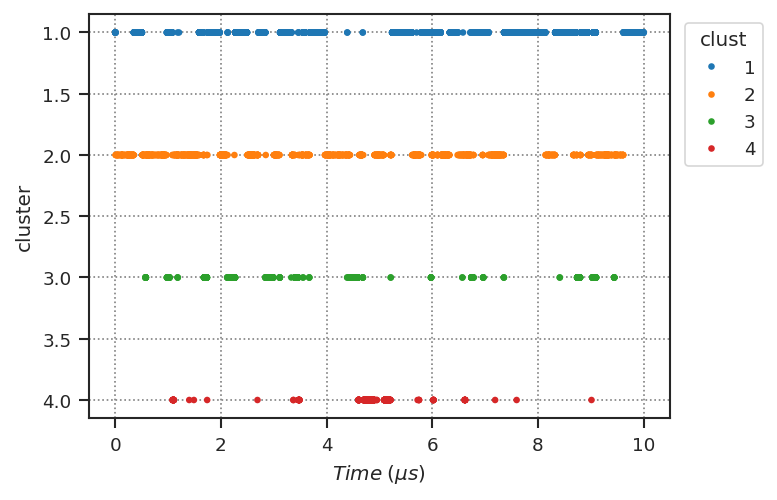

In [43]:
data_plot.plot_scatter(
    df_300,
    time_ax_name,
    "clust",
    "clust",
    x_label=r'$Time\; (\mu s)$',
    y_label=r'cluster')

<Axes: xlabel='$Time\\; (\\mu s)$', ylabel='$RMSD\\; (nm)$'>

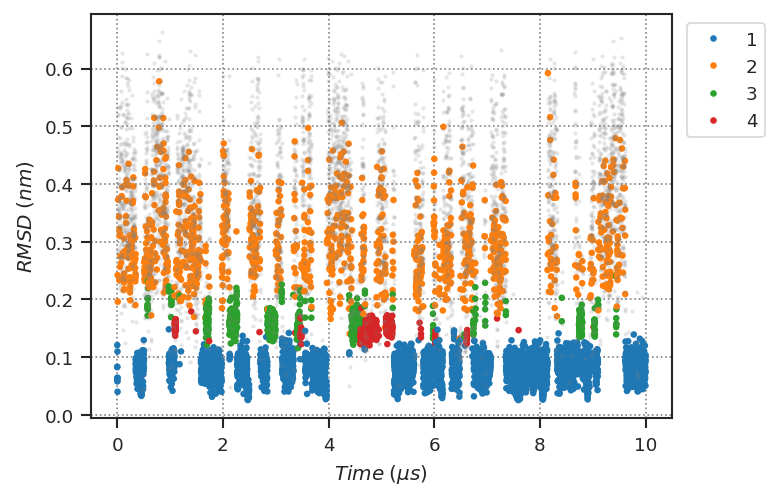

In [44]:
data_plot.plot_scatter(
    df_300,
    time_ax_name,
    "RMSD (nm)",
    "clust",
    x_label=r'$Time\; (\mu s)$',
    y_label=r'$RMSD\; (nm)$')

data_plot.plot_scatter(
    df_300[df_300.clust.isnull()],
    time_ax_name,
    "RMSD (nm)",
    x_label=r'$Time\; (\mu s)$',
    y_label=r'$RMSD\; (nm)$',
    color='gray', s=4, alpha=0.2,
    legend=False)

<Axes: xlabel='PC 1', ylabel='PC 2'>

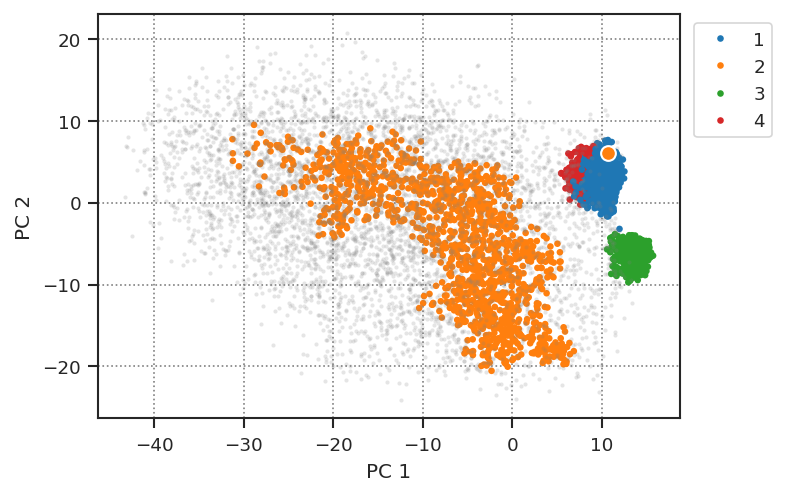

In [45]:
data_plot.plot_scatter(
    df_300,
    x="PC_1", y="PC_2", hue="clust",
    x_label="PC 1",
    y_label="PC 2")
data_plot.plot_scatter(
    df_300[df_300.clust.isnull()],
    x="PC_1", y="PC_2",
    x_label="PC 1",
    y_label="PC 2",
    color='gray', s=4, alpha=0.2,
    legend=False)
data_plot.plot_scatter(
    pca_ref_df,
    x="PC_1", y="PC_2",
    x_label="PC 1", label=ref_name,
    y_label="PC 2", s=50, linewidth=1)

<Axes: xlabel='PC_1', ylabel='PC_2'>

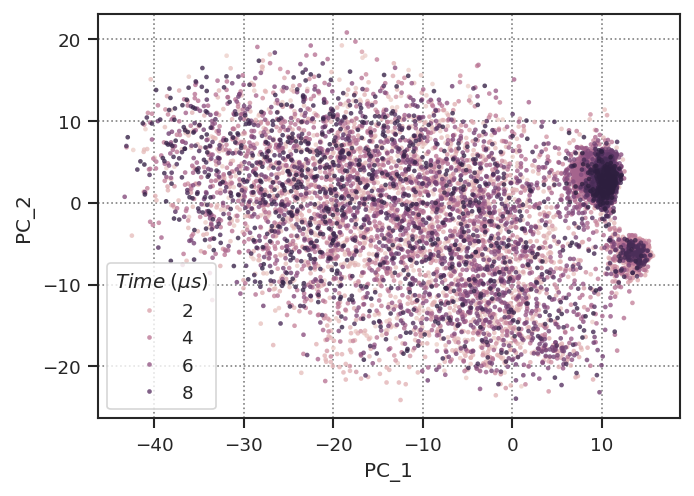

In [46]:
sns.scatterplot(data=df_300,
                x="PC_1", y="PC_2",
                hue=time_ax_name,
                s=5,
                alpha=0.8,
                linewidth=0)

In [47]:
center_frame = []

dt = md.trajectory.dt

md_noh = md.select_atoms(f"protein and not name H* and ({pep_Sel})")
md_noh.write("tmp_ref.pdb")

ref_tmp = mda.Universe('tmp_ref.pdb')
ref_sel = ref_tmp.select_atoms(f"protein and not name H* and ({pep_Sel})")

n_clusters_ = len(df_300['clust'].unique())

for clust in range(1, n_clusters_):
    indexes = [i for i, val in enumerate(df_300['clust']) if val==clust]
    print(f'Cluster : {clust:3}, num: {len(indexes):6}')
    
    # Compute avg structures:
    p_avg = np.zeros_like(md_noh.atoms.positions)

    # do a quick average of the protein (in reality you probably want to remove PBC and RMSD-superpose)
    for ts in md.trajectory[indexes]:
        p_avg += md_noh.atoms.positions
    p_avg /= len(indexes)
    ref_sel.atoms.positions = p_avg
    
    min_rmsd = np.inf
    step = 0
    frame = 0
    for ts in md.trajectory[indexes]:
        R = mda.analysis.rms.rmsd(md_noh.atoms.positions, ref_sel.atoms.positions)
        if R<min_rmsd:
            min_rmsd = R
            frame = ts.frame
            time= ts.time
    
    local_df = df_300[df_300.clust == clust]
    
    print(f'\t closest structure : {frame:6},   size= {len(indexes):6}   RMSD={local_df["RMSD (nm)"].mean():.2f}')
    center_frame.append([clust, frame, len(indexes)])

/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniforge3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniforge3/envs/openmm/lib/pytho

Cluster :   1, num:   5346
	 closest structure :  10640,   size=   5346   RMSD=0.08
Cluster :   2, num:   1382
	 closest structure :  11659,   size=   1382   RMSD=0.30
Cluster :   3, num:    865
	 closest structure :   2684,   size=    865   RMSD=0.16
Cluster :   4, num:    504
	 closest structure :   6503,   size=    504   RMSD=0.15


In [48]:
df_300[(df_300.clust==1) & (df_300["RMSD (nm)"]<0.2)].tail(100)

,level_0,index,Aim Temp (K),E solute scaled (kJ/mole),E solute not scaled (kJ/mole),E solvent (kJ/mole),E solvent-solute (kJ/mole),Step,Potential Energy (kJ/mole),Total Energy (kJ/mole),...,Temp Change index,E solvent-solute (kJ/mole) scaled,new_pot,RMSD (nm),COM dist (Å),Gyration radius (nm),Native Contact,PC_1,PC_2,clust
12399,247980,4959600,280.000,-699.878,475.906,-168878,-2623.44,2479800500,-171867.833843,-141663.920598,...,2.0,-1357.759193,-2057.637193,0.080716,0.094438,0.523355,0.884966,11.738961,3.515383,1
12400,248000,4960000,347.488,-603.634,410.381,-168715,-2427.54,2480000500,-171081.644101,-140548.799965,...,-1.0,-1127.787095,-1731.421095,0.075798,0.082631,0.510529,0.871960,10.614135,2.225125,1
12401,248020,4960400,373.980,-592.330,419.061,-168712,-2243.52,2480200500,-170777.320846,-140173.663427,...,-1.0,-1004.699968,-1597.029968,0.096357,0.140773,0.544631,0.880770,11.115233,2.471086,1
12402,248040,4960800,280.000,-640.573,414.755,-167855,-2697.09,2480400500,-170917.886836,-139928.504579,...,1.0,-1395.876690,-2036.449690,0.101926,0.146791,0.549222,0.883044,11.266029,1.925590,1
12403,248060,4961200,373.980,-609.011,540.699,-168345,-2413.10,2480600500,-170453.853292,-139710.828586,...,1.0,-1080.641801,-1689.652801,0.082961,0.115530,0.563431,0.882528,9.041680,1.622647,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,249900,4998000,280.000,-692.674,520.357,-168403,-2634.24,2499000500,-171351.768142,-140704.288517,...,2.0,-1363.348724,-2056.022724,0.074454,0.088458,0.518385,0.865251,11.351230,2.760793,1
12496,249920,4998400,322.872,-630.762,476.923,-168745,-2524.49,2499200500,-171287.615712,-140780.733476,...,-1.0,-1216.715651,-1847.477651,0.050339,0.033313,0.532816,0.850909,9.506574,3.882400,1
12497,249940,4998800,300.000,-623.284,507.519,-168397,-2692.20,2499400500,-171204.652240,-140098.918319,...,1.0,-1346.100000,-1969.384000,0.094184,0.099504,0.514908,0.864680,9.867235,1.217985,1
12498,249960,4999200,322.872,-601.313,468.990,-168240,-2477.92,2499600500,-170718.125951,-139599.075808,...,1.0,-1194.270544,-1795.583544,0.072996,0.112237,0.532104,0.859827,9.991739,2.318866,1


In [49]:
view = nv.show_mdanalysis(md)
view.add_component(ref_coor[0])
view.clear_representations(1)
view[1].add_cartoon(selection="protein", color='blue')
view[1].add_licorice(selection=":A", color='blue')
view[0].add_licorice(selection=":A")

from ipywidgets import interact

def update(n):
    
    local_df = df_300[df_300.clust == n]
    
    view.frame = center_frame[n-1][1]
    print(f"Cluster {n}, size={center_frame[n-1][2]}, frame={center_frame[n-1][1]}, RMSD={local_df['RMSD (nm)'].mean():.2f}")

interact(update, n=range(1, len(center_frame)+1));

view

interactive(children=(Dropdown(description='n', options=(1, 2, 3, 4), value=1), Output()), _dom_classes=('widg…

NGLWidget(frame=10640, max_frame=12499)

In [50]:
show_matrix = False

if show_matrix:

    from MDAnalysis.analysis import diffusionmap

    matrix = diffusionmap.DistanceMatrix(md, select=f'backbone and ({pep_Sel})',
                                         verbose=True, pairwise_align=False).run(step=20)

In [51]:
if show_matrix:
    
    # WARNING: time is not continuous as only 300K frames are shown

    max_RMSD = df_300["RMSD (nm)"].max() * 10 # Angstrom

    last_time = df_300.iloc[-1][time_ax_name]

    plt.imshow(matrix.dist_matrix,
               cmap='viridis',
               vmax=max_RMSD,
               extent=[0, last_time, last_time, 0])
    plt.xlabel(time_ax_name)
    plt.ylabel(time_ax_name)
    plt.colorbar(label=r'RMSD ($\AA$)')

In [52]:
print(f"vmd {OUT_PATH}/noh_300K_skip.pdb {traj_filter}"\
      f" -m ../REST2_test/{ref_coor[0]} -e ../REST2_test/visualize_pep.tcl")

vmd CLN025_sst2_10_rung_5awl_2ps_pad_3.0_1//noh_300K_skip.pdb CLN025_sst2_10_rung_5awl_2ps_pad_3.0_1//noh_skip.xtc -m ../REST2_test/5awl.pdb -e ../REST2_test/visualize_pep.tcl


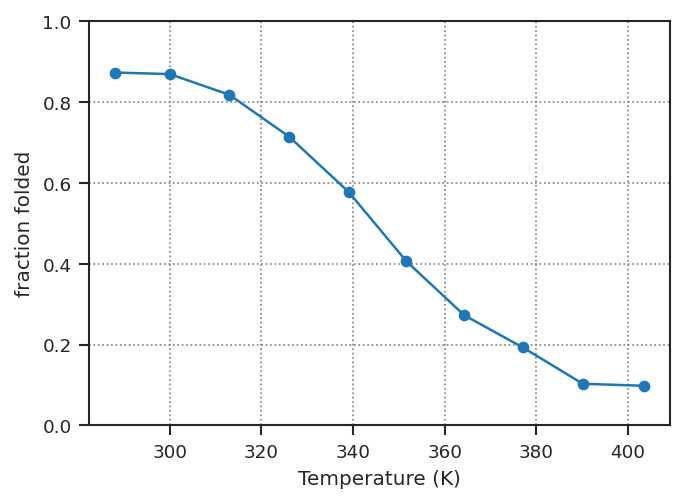

In [53]:
if not use_only_300:
    
    rmsd_cutoff = 0.2
    
    data_plot.plot_folding_fraction(
        df_300,
        cutoff=rmsd_cutoff,
        recompute_temp_flag=True,
        label=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


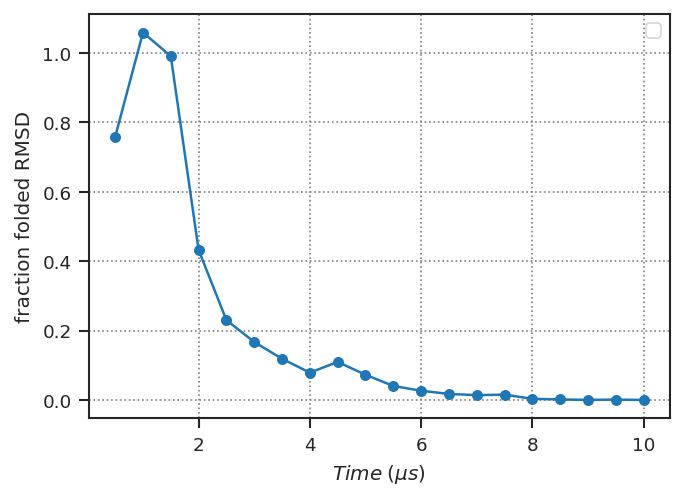

In [54]:
if not use_only_300:    
    data_plot.plot_folding_fraction_RMSD(
        df_300, time_interval=0.5,
        cutoff=rmsd_cutoff,
        start_time=0.0)

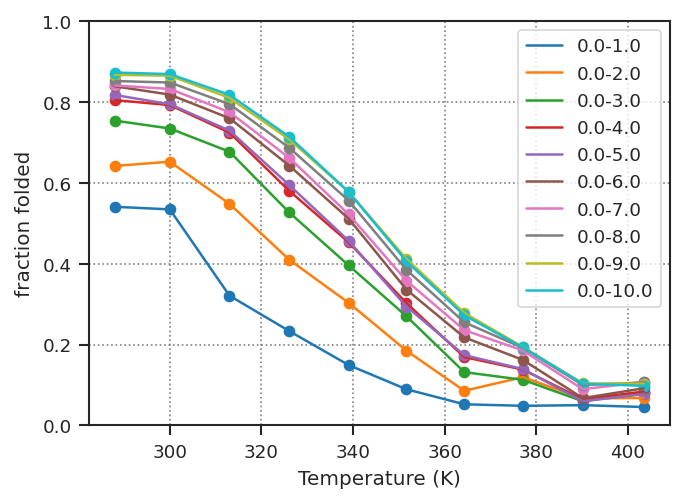

In [55]:
if not use_only_300:  
    
    data_plot.plot_folding_fraction_convergence(
        df_300, time_interval=1,
        recompute_temp_flag=True,
        cutoff=rmsd_cutoff,
        start_time=0.0)

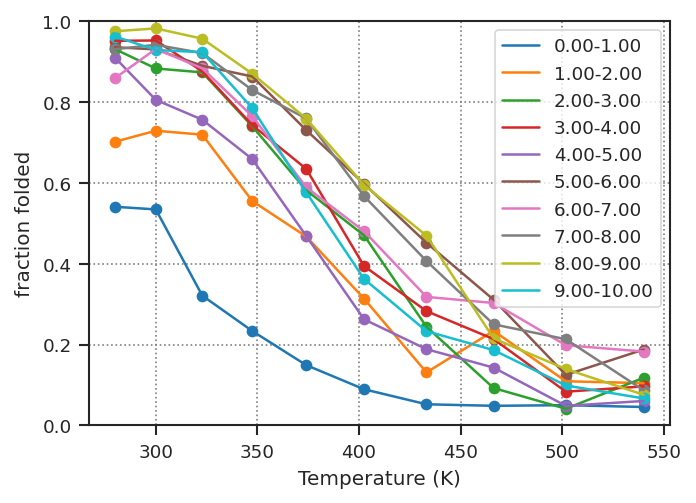

In [56]:

def plot_folding_fraction_interval(df, col="RMSD (nm)", cutoff=0.2, label=None,
    start_time=0, time_ax_name=r"$Time\;(\mu s)$", recompute_temp_flag=False,
    ref_temp=300.0, time_interval=2.0):

    temp_list = df['Aim Temp (K)'].unique()
    temp_list.sort()


    if recompute_temp_flag:
        if ref_temp not in temp_list:
            ref_temp = temp_list[np.argmin(abs(temp_list-300))]
        temp_list_plot = data_plot.recompute_temp(df, ref_temp=ref_temp)
    else:
        temp_list_plot = temp_list
    
    max_time = df[time_ax_name].max()
    #logger.info(max_time)
    
    for i in range( int((max_time-start_time)/time_interval) + 1):
        #print(f"{i}  {start_time:.1f}  {start_time + (i + 1) * time_interval:.1f}")
    

        df_time = df[(df[time_ax_name] > start_time + i * time_interval) &
                     (df[time_ax_name] < start_time + (i + 1) * time_interval)]
        
        fold_frac = data_plot.compute_folding_fraction(
            df_time, col, cutoff)
                
        plt.plot(temp_list_plot, fold_frac, label=f"{start_time + i * time_interval:.2f}-{start_time + (i + 1) * time_interval:.2f}")
        plt.scatter(temp_list_plot, fold_frac)
    
    plt.xlabel('Temperature (K)')
    plt.ylabel('fraction folded')
    plt.ylim((0,1.0))
    plt.legend()

plot_folding_fraction_interval(
    df_300,
    cutoff=0.2,
    time_interval=1,
    start_time=0.
)

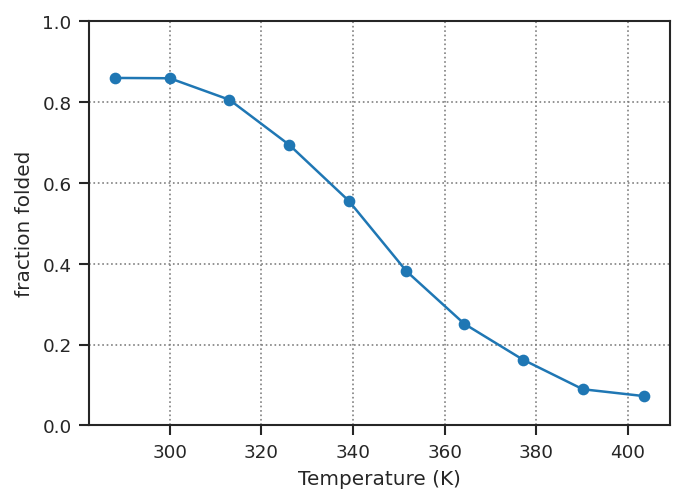

In [57]:
around_300 = temp_list[np.argmin(abs(temp_list-300))]


if not use_only_300:
    data_plot.plot_folding_fraction(df_300, ref_temp=around_300) #[df_300[time_ax_name]>0.15])

<Axes: xlabel='$Time\\;(\\mu s)$', ylabel='RMSD (nm)'>

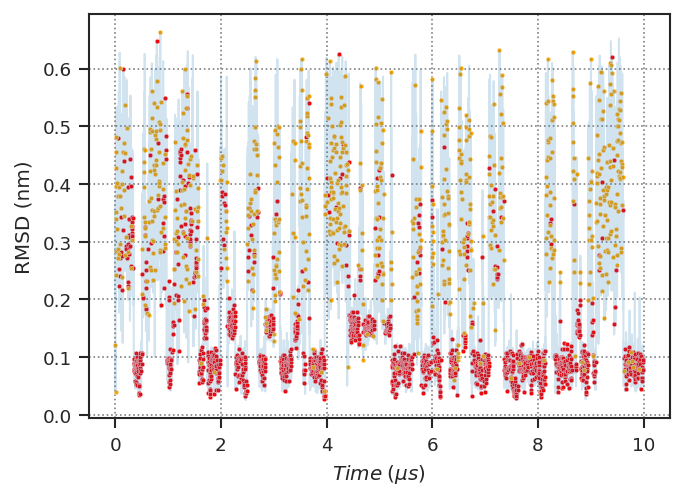

In [58]:
sns.lineplot(data=df_300,
             x=time_ax_name,
             y="RMSD (nm)", alpha=0.2, linewidth=1)
sns.scatterplot(data=df_300[df_300["Aim Temp (K)"] == temp_list[1]],
             x=time_ax_name, color='red', s=5,
             y="RMSD (nm)")
sns.scatterplot(data=df_300[df_300["Aim Temp (K)"] == temp_list[-1]],
             x=time_ax_name, color='orange', s=5,
             y="RMSD (nm)")

In [59]:
msd = False

if msd:

    from MDAnalysis.analysis.waterdynamics import MeanSquareDisplacement as MSD
    from scipy import stats

    tot_time = md.trajectory.dt * md.trajectory.n_frames
    print(f"Total simulation time should be {tot_time/1000:.2f} ns")

    lag_time = 20 #ns
    end_time = int(lag_time * 1000/md.trajectory.dt)

    MSD = MSD(md, pep_Sel, 0, md.trajectory.n_frames, end_time)
    MSD.run()

    dt = md.trajectory.dt
    time = np.arange(0.0, dt*len(MSD.timeseries), dt)

    start_time = 5 #ns
    start_frame = int(start_time * 1000/md.trajectory.dt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        time[start_frame:],MSD.timeseries[start_frame:])
    estimate = time*slope + intercept

    print("D (10-6 m**2/s) =", 1000*slope/0.6)

In [60]:
if msd:
    # Plot
    # sns.set_theme(style="ticks")

    plt.xlabel('time (ns)')
    plt.ylabel('MSD ($\\AA^2$)')
    plt.semilogy(time/1000, MSD.timeseries,
                 'ro', label=f"D = {1000*slope/0.6:.2f}"+"  $10^{-6}.m^2.s^{-1}$")
    plt.semilogy(time/1000, estimate, color="black", linestyle=":")
    plt.legend()
    plt.legend(bbox_to_anchor=(0.24, 0.55))
    plt.show()